Using device: cuda
Epoch [1/20], Training Loss: 0.9116620254516602
Epoch [1/20], Validation Loss: 0.9201523780822753
Epoch [2/20], Training Loss: 0.9086454033851623
Epoch [2/20], Validation Loss: 0.9188696432113648
Epoch [3/20], Training Loss: 0.906724305152893
Epoch [3/20], Validation Loss: 0.9169847941398621
Epoch [4/20], Training Loss: 0.9029539394378662
Epoch [4/20], Validation Loss: 0.9067032623291016
Epoch [5/20], Training Loss: 0.8813835334777832
Epoch [5/20], Validation Loss: 0.8574524426460266
Epoch [6/20], Training Loss: 0.8434988665580749
Epoch [6/20], Validation Loss: 0.8260202503204346
Epoch [7/20], Training Loss: 0.8272419428825378
Epoch [7/20], Validation Loss: 0.8138899111747742
Epoch [8/20], Training Loss: 0.8197708249092102
Epoch [8/20], Validation Loss: 0.8058167791366577
Epoch [9/20], Training Loss: 0.8132975482940674
Epoch [9/20], Validation Loss: 0.7997079539299011
Epoch [10/20], Training Loss: 0.804395101070404
Epoch [10/20], Validation Loss: 0.7885543918609619
E

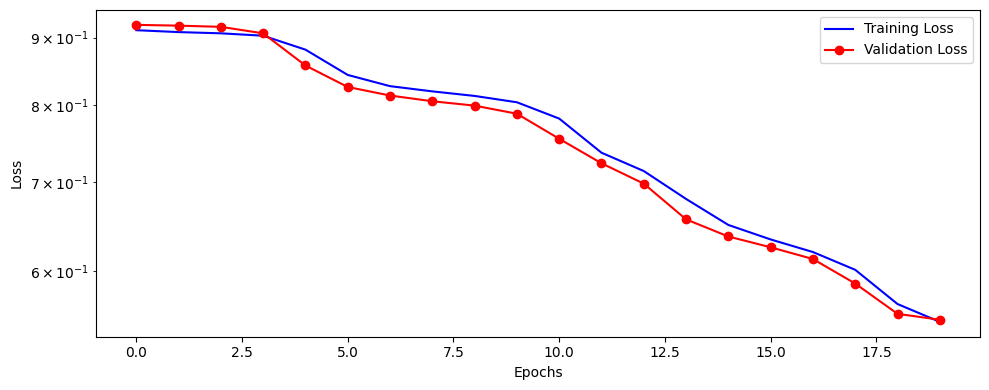

Prediction for the example data point: Anomalous


In [49]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Define the LSTM-Autoencoder model
class LSTM_Autoencoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(LSTM_Autoencoder, self).__init__()
        self.encoder = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.repeat_vector = nn.Linear(hidden_size, input_size)
        self.decoder = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, input_size)
    
    def forward(self, x):
        _, (hidden, _) = self.encoder(x)
        repeated = self.repeat_vector(hidden[-1])  # Take the last hidden state
        repeated = repeated.unsqueeze(1).repeat(1, x.size(1), 1)  # Repeat vector across timesteps
        decoded, _ = self.decoder(repeated)
        output = self.fc(decoded)
        return output

# Load and preprocess the data
data = pd.read_csv("can_data.csv")
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data.iloc[:, :-1])

# Convert data to PyTorch tensors and move to device
X = torch.tensor(data_scaled, dtype=torch.float32).to(device)
y = torch.tensor(data.iloc[:, -1].values, dtype=torch.float32).to(device)

# Create TensorDataset
dataset = TensorDataset(X, y)

# Define hyperparameters
input_size = X.size(1)  # Excluding the label column
hidden_size = 64
num_layers = 2
batch_size = 64
num_epochs = 20
learning_rate = 0.001

# Split the dataset into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# Create DataLoader for training
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Create DataLoader for validation
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Initialize model, loss function, and optimizer
model = LSTM_Autoencoder(input_size, hidden_size, num_layers).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
losses = []
val_losses = []
for epoch in range(num_epochs):
    epoch_loss = 0.0
    for data, _ in train_dataloader:
        optimizer.zero_grad()
        output = model(data.unsqueeze(1))  # Add extra dimension for LSTM input
        loss = criterion(output.squeeze(), data)  # Calculate reconstruction loss
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * data.size(0)  # Accumulate loss for the entire batch
    epoch_loss /= len(train_dataset)  # Average loss per sample in the training dataset
    losses.append(epoch_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {epoch_loss}")
    
    # Validation loop
    val_loss = 0.0
    with torch.no_grad():
        for data, _ in val_dataloader:
            output = model(data.unsqueeze(1))
            loss = criterion(output.squeeze(), data)
            val_loss += loss.item() * data.size(0)  # Accumulate loss for the entire batch
        val_loss /= len(val_dataset)  # Average loss per sample in the validation dataset
        val_losses.append(val_loss)
        print(f"Epoch [{epoch+1}/{num_epochs}], Validation Loss: {val_loss}")

# Save the trained model
torch.save(model.state_dict(), 'lstm_autoencoder_model.pth')

# Plotting
plt.figure(figsize=(10, 4))
plt.plot(losses, label='Training Loss', c='b')
plt.plot(val_losses, label='Validation Loss', c='r', marker='o')
plt.yscale('log')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

# Load the saved model
loaded_model = LSTM_Autoencoder(input_size, hidden_size, num_layers).to(device)
loaded_model.load_state_dict(torch.load('lstm_autoencoder_model.pth'))
loaded_model.eval()  # Set the model to evaluation mode

# Function to predict whether a CAN message is normal or not
anomaly_threshold = 0.5  # Adjust according to your data
def predict_can_message(data):
    with torch.no_grad():
        output = loaded_model(data.unsqueeze(0).unsqueeze(0))  # Add extra dimensions for batch and LSTM input
        loss = criterion(output.squeeze(), data)  # Calculate reconstruction loss
        if loss.item() > anomaly_threshold:
            return "Anomalous"
        else:
            return "Normal"

# Example usage
example_data = X[0]  # Taking the first data point as an example
prediction = predict_can_message(example_data)
print("Prediction for the example data point:", prediction)
